# KNN 분류기를 이용한 숫자 인식

In [1]:
import numpy as np , cv2
import matplotlib.pyplot as plt

In [2]:
# 숫자 객체 셀 중심 배치
def place_middle(number, new_size):
    h, w = number.shape[:2]
    big = max(h, w)
    square = np.full((big, big), 255, np.float32)  # 실수 자료형

    dx, dy = np.subtract(big, (w,h))//2
    square[dy:dy + h, dx:dx + w] = number
    return cv2.resize(square, new_size).flatten()  # 크기변경 및 벡터변환 후 반환

def find_value_position(img, direct):
    project = cv2.reduce(img, direct, cv2.REDUCE_AVG).ravel()
    p0, p1 = -1, -1                                                 # 초기값
    len = project.shape[0]                                   # 전체 길이
    for i in range(len):
        if p0 < 0 and project[i] < 250: p0 = i
        if p1 < 0 and project[len-i-1] < 250 : p1 = len-i-1
    return p0, p1

def find_number(part):
    x0, x1 = find_value_position(part, 0)  # 수직 투영
    y0, y1 = find_value_position(part, 1)  # 수평 투영
    return part[y0:y1, x0:x1]

def get_cell(img, j, i, size):
    x, y = (j * size[0], i * size[1])  # 숫자칸 시작좌표
    return img[y:y + size[1], x:x + size[0]]

In [3]:
train_image = cv2.imread('img/train_numbers.png', cv2.IMREAD_GRAYSCALE)
if train_image is None: raise Exception("영상 파일 읽기 에러")
train_image = train_image[5:405, 6:806] # 여백 제거 

# 학습 행렬을 nclass 행, nsample 열로 분리
size, K = (40, 40),  15                                 # 숫자 영상 크기
nclass, nsample = 10, 20                                # 그룹수, 그룹당 샘플수
cv2.threshold(train_image, 32, 255, cv2.THRESH_BINARY, train_image)

(32.0,
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8))

In [4]:
cells = [np.hsplit(row, nsample) for row in np.vsplit(train_image, nclass)]
nums = [find_number(c) for c in np.reshape(cells, (-1, 40, 40))]
trainData = np.array([place_middle(n, size) for n in nums])
labels= np.array([ i for i in range(nclass) for j in range(nsample)], np.float32)

In [5]:
print('cells 형태:', np.array(cells).shape)
print('nums 형태:', np.array(nums).shape)
print('trainData 형태:',trainData.shape)
print('labels 형태:',labels.shape)

cells 형태: (10, 20, 40, 40)
nums 형태: (200,)
trainData 형태: (200, 1600)
labels 형태: (200,)


In [6]:
knn = cv2.ml.KNearest_create()
knn.train(trainData, cv2.ml.ROW_SAMPLE, labels)       # k-NN 학습 수행

True

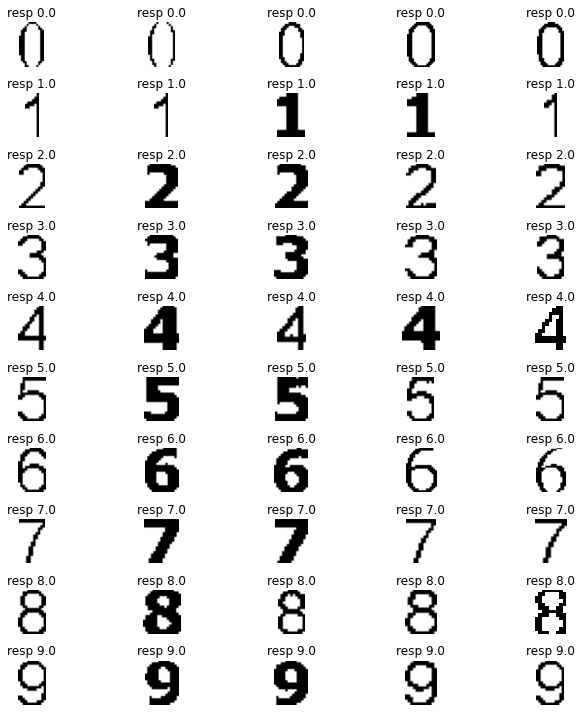

(None, None)

In [7]:
plt.figure(figsize=(10,10))

for i in range(50):
    test_img = cv2.imread('img/num/%d%d.png' % (i / 5 , i % 5), cv2.IMREAD_GRAYSCALE)
    cv2.threshold(test_img, 128, 255, cv2.THRESH_BINARY, test_img)  # 이진화

    num = find_number(test_img) # 숫자 객체 가져오기 
    data = place_middle(num, size)  # 숫자 객체 중심 배치
    data = data.reshape(1, -1) # 1행 행렬로 변경 

    _, [[resp]], _, _ = knn.findNearest(data, K)  # 숫자 분류 수행
    plt.subplot(10, 5, i+1), plt.axis('off'), plt.imshow(num, cmap='gray')
    plt.title('resp ' + str(resp))
    
plt.tight_layout(), plt.show()